# HW8 

## Q1 Perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Data set chose for this question is from Kaggle (url: https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset/data). The data originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The data set contains patients who are at least 21 years old females with Pima Indian heritage. Some (clinical) variables in the data set used to examine diabetes includes age, number of pregnancies, BMI, level of insulin, glucose, etc..And our respond variable is a binary variable with 1 represents diabetes and 0 for no diabetes. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df1 = pd.read_csv("diabetes.csv")
df1 = df1

### Data viewing and data cleaning

In [4]:
print("Dataset shape:", df1.shape)

Dataset shape: (768, 9)


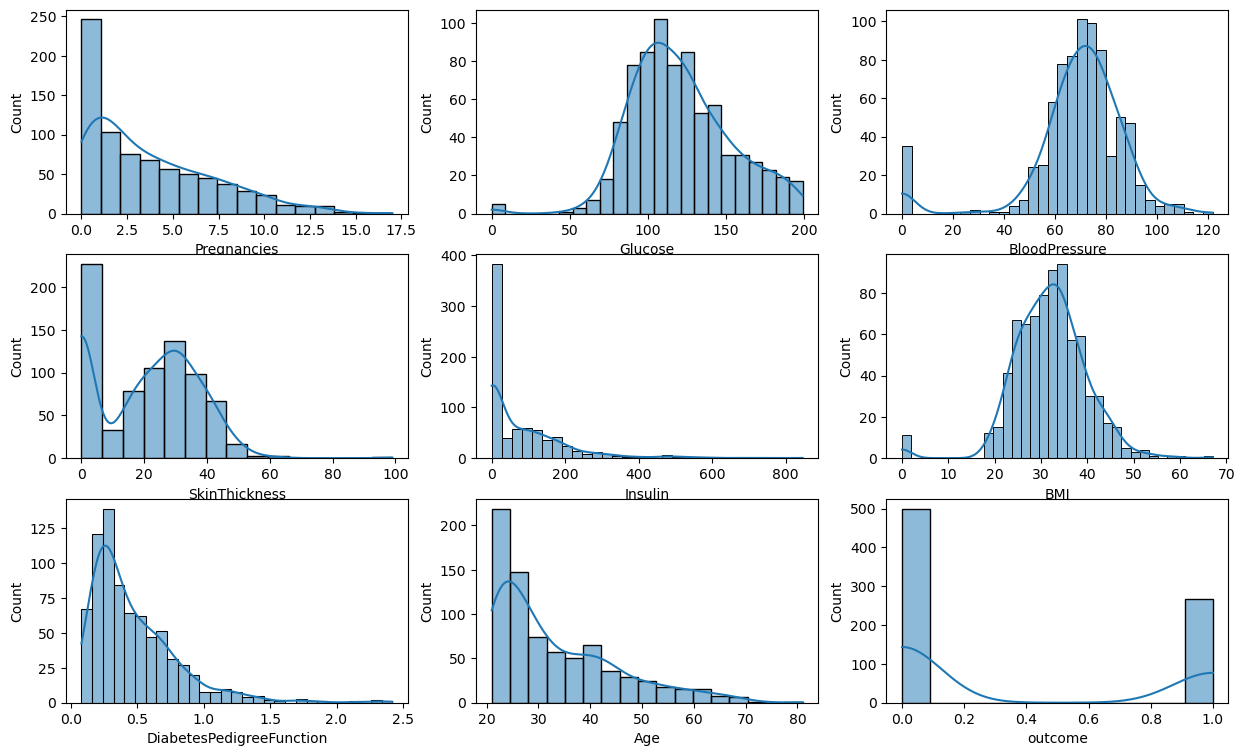

In [5]:
# check the data distribution:
%matplotlib inline
fig, ax = plt.subplots(3,3,figsize=(15,9))
for i, col in enumerate(df1):
    sns.histplot(df1[col], kde=True, ax=ax[i//3, i%3])
    # plt.title(f"{col} ditribution", fontsize=14, fontweight='bold', c='r')
plt.show()

So the data contains 9 columns and 768 observations

In [6]:
df1.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
outcome                     0
dtype: int64

There is no missing value in the dataset, which is good :)

In [7]:
df1.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [8]:
df1['outcome'].unique()

array([1, 0])

In [9]:
df1.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'outcome'],
      dtype='object')

There is no "strange" value in the response variables.

In [10]:
for i in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'outcome']:
    unique_value = df1[i].unique()
    print(f"{'-'*50}")
    print(f"Variable: {i}")
    print(f"Total unique values: {len(unique_value)}")
    print(f"Unique values: {np.sort(unique_value)}\n")

--------------------------------------------------
Variable: Pregnancies
Total unique values: 17
Unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]

--------------------------------------------------
Variable: Glucose
Total unique values: 136
Unique values: [  0  44  56  57  61  62  65  67  68  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188
 189 190 191 193 194 195 196 197 198 199]

--------------------------------------------------
Variable: BloodPressure
Total unique values: 47
Unique values: [  0  24  30  38  40  44  46  48  50  52  54  55  56  58 

In [11]:
for c in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    print('The number of zero values of',c, 'is:', (df1[c]==0).sum())

The number of zero values of Glucose is: 5
The number of zero values of BloodPressure is: 35
The number of zero values of SkinThickness is: 227
The number of zero values of Insulin is: 374
The number of zero values of BMI is: 11


The variable "age" and "pregnancies" seems good. All datas in these two variables are reasonable. However in the 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI' the zero value is not reasonable. But when I check these five columns whose value is zero, the number of observations whose insulin and skin thickness level is zero is almost (more than) 30% of total data we have. This is pretty large, and removing them would loss at least 374 observations (very close to half). For the purpose of this homework I would impute those value as median (mean), though in the realitu I shouldn't do that. Also notice that "BMI" has very large value(perhaps more than 50). I am not sure if that is reasonale or not but again for the purpose of this homework I decide to keep those. Finally for the insulin level there is some extremely high values, > 600-800, which is weird. So I could cap those values at 500. One last thing to notify is that the "skin thickness" level has outlier at 99, which also seems weird. Since the number of outlier is small, I would cap all values >= 60 to 50. 

In [6]:
df_clean = df1.copy().drop(columns=['DiabetesPedigreeFunction'])

In [7]:
# replace those zero value not reasonable to mean/median of the variable.
zero_val = ['Glucose','Insulin','SkinThickness','BloodPressure','BMI']
df_clean[zero_val] = df_clean[zero_val].replace(0, np.nan)
#df_clean.isna().sum()

for col in ['Glucose','Insulin','SkinThickness']:
    median_col = np.median(df_clean[df_clean[col].notna()][col])
    df_clean[col] = df_clean[col].fillna(median_col)
    
for col in ['BMI','BloodPressure']:
    mean_col = np.mean(df_clean[df_clean[col].notna()][col])
    df_clean[col] = df_clean[col].fillna(mean_col)

In [8]:
df_clean['Insulin'] = df_clean['Insulin'].clip(upper=500) #cap >600~800 to 500

In [9]:
df_clean['SkinThickness'] = df_clean['SkinThickness'].clip(upper=50) #cap >60 to 60

Now the data should be cleaned, and is ready to be analyzed.

## Bayesian Logistic model

In [13]:
X = df_clean.drop(columns="outcome")
y = df_clean["outcome"]
X

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  Age
0              6    148.0           72.0           35.0    125.0  33.6   50
1              1     85.0           66.0           29.0    125.0  26.6   31
2              8    183.0           64.0           29.0    125.0  23.3   32
3              1     89.0           66.0           23.0     94.0  28.1   21
4              0    137.0           40.0           35.0    168.0  43.1   33
..           ...      ...            ...            ...      ...   ...  ...
763           10    101.0           76.0           48.0    180.0  32.9   63
764            2    122.0           70.0           27.0    125.0  36.8   27
765            5    121.0           72.0           23.0    112.0  26.2   30
766            1    126.0           60.0           29.0    125.0  30.1   47
767            1     93.0           70.0           31.0    125.0  30.4   23

[768 rows x 7 columns]

In [11]:
#Standardized predictor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Add intercept
X_scaled = np.column_stack((X_scaled, np.ones(X_scaled.shape[0])))

In [127]:
with pm.Model() as model:
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_scaled.shape[1])
    logits = pm.math.dot(X_scaled, betas)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)
    trace = pm.sample(draws=3000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
betas[0]  0.40  0.11    0.19     0.59        0.0      0.0  14709.39   9713.13   
betas[1]  1.14  0.12    0.93     1.37        0.0      0.0  14260.89  10105.27   
betas[2] -0.12  0.10   -0.31     0.07        0.0      0.0  17820.30  10168.77   
betas[3]  0.05  0.11   -0.17     0.26        0.0      0.0  15548.70   9908.59   
betas[4] -0.05  0.10   -0.23     0.14        0.0      0.0  16059.70   9656.04   
betas[5]  0.66  0.12    0.43     0.88        0.0      0.0  14451.08  10241.31   
betas[6]  0.16  0.11   -0.04     0.37        0.0      0.0  14448.69  10130.33   
betas[7] -0.86  0.10   -1.04    -0.67        0.0      0.0  17440.92   9065.71   

          r_hat  
betas[0]    1.0  
betas[1]    1.0  
betas[2]    1.0  
betas[3]    1.0  
betas[4]    1.0  
betas[5]    1.0  
betas[6]    1.0  
betas[7]    1.0  


array([[<Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>,
        <Axes: title={'center': 'betas\n3'}>],
       [<Axes: title={'center': 'betas\n4'}>,
        <Axes: title={'center': 'betas\n5'}>,
        <Axes: title={'center': 'betas\n6'}>,
        <Axes: title={'center': 'betas\n7'}>]], dtype=object)

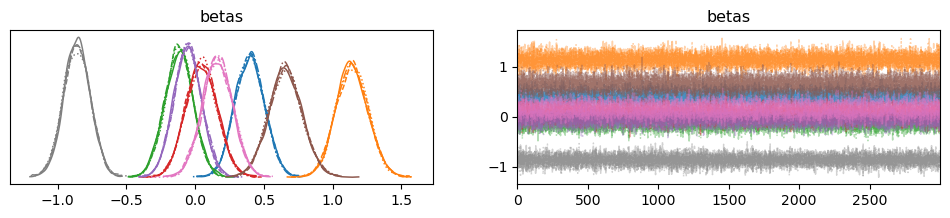

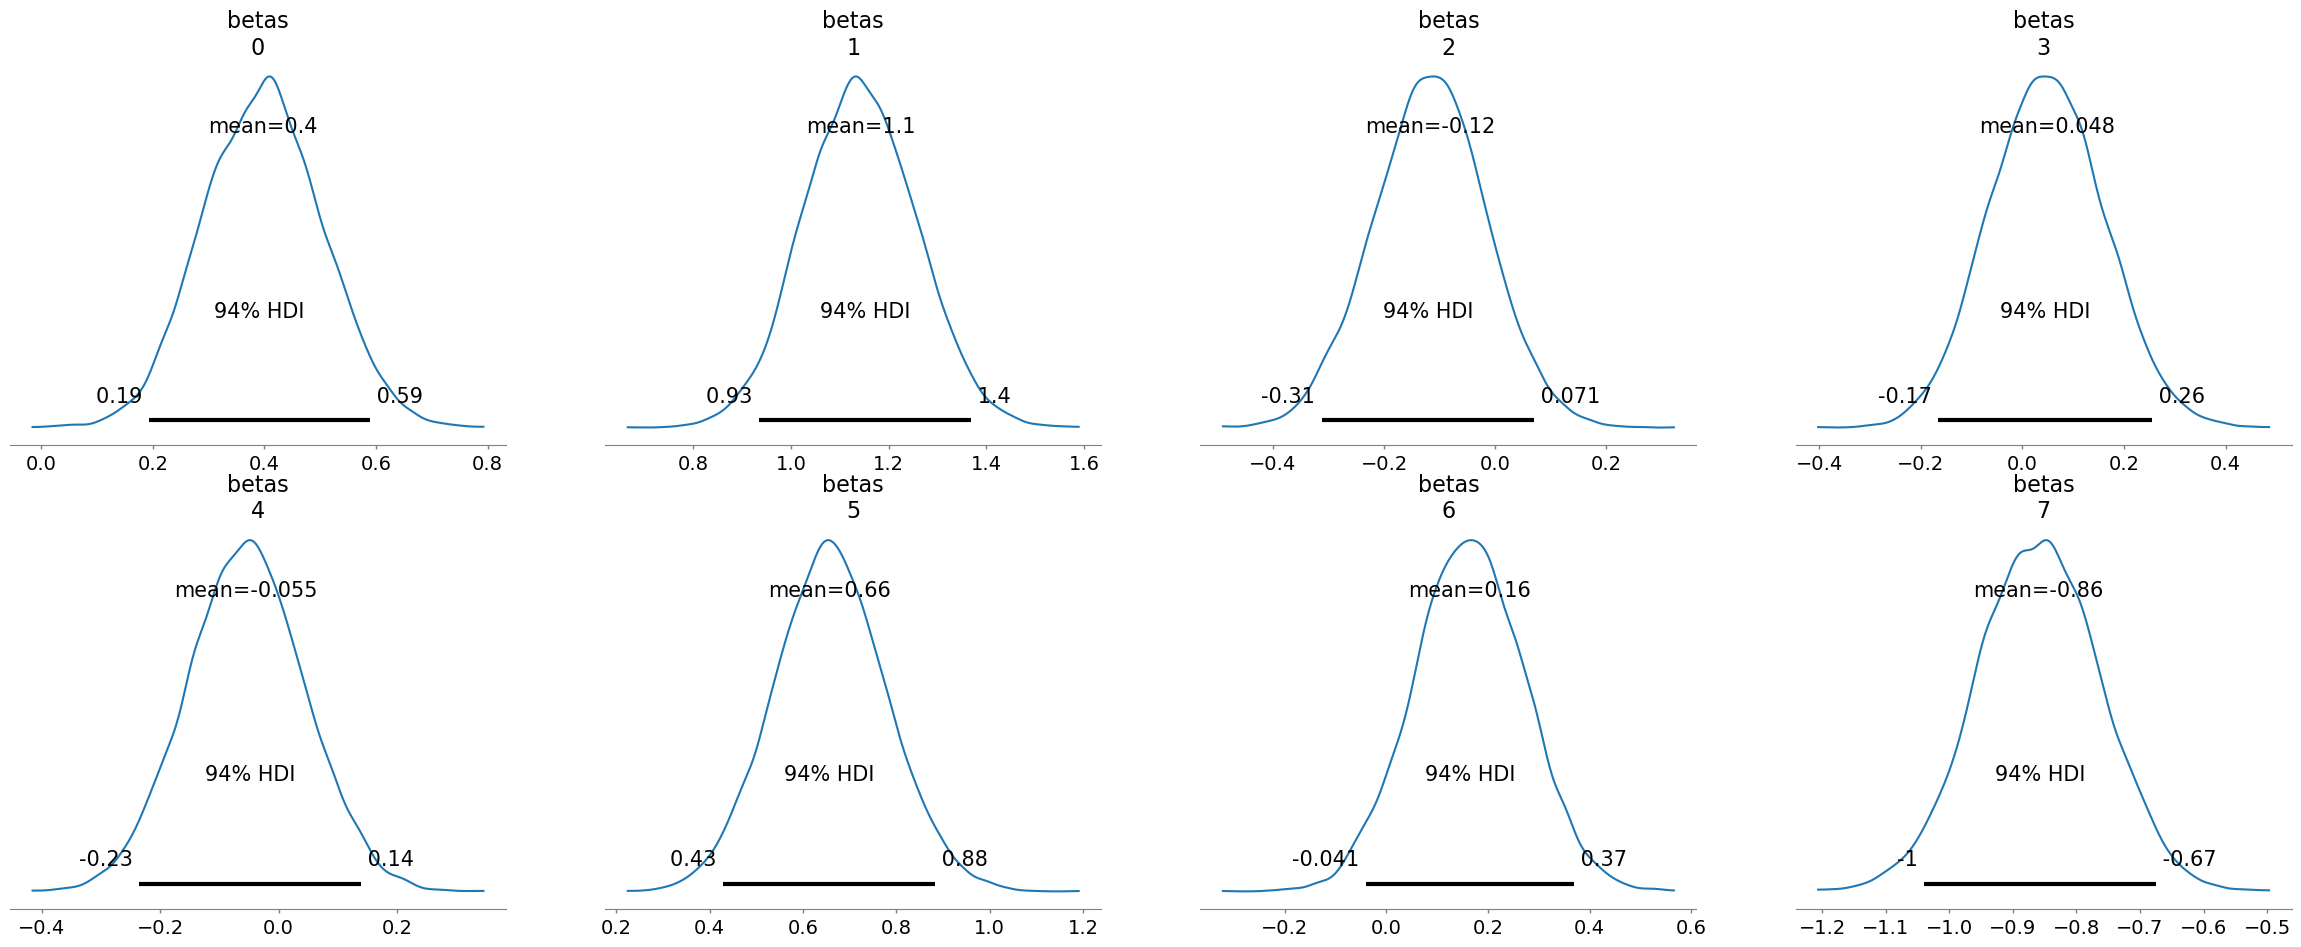

In [128]:
# Posterior Summary
summary = az.summary(trace, round_to=2)
print(summary)

# Diagnostic Plots
az.plot_trace(trace)
az.plot_posterior(trace)

<Axes: >

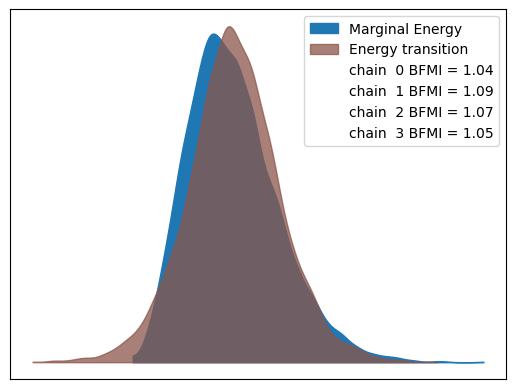

In [130]:
az.plot_energy(trace)

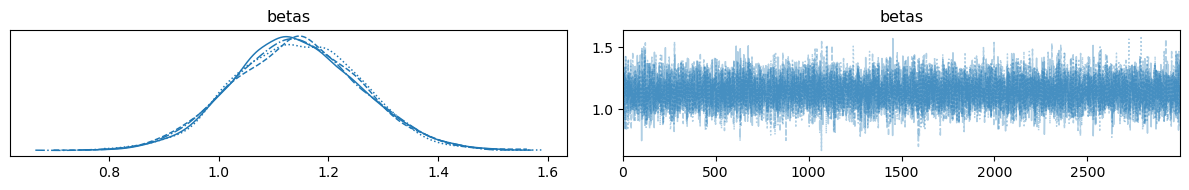

In [146]:
az.plot_trace(trace, var_names=["betas"], coords={"betas_dim_0": [1]})
plt.tight_layout()
plt.show()

To ensure the reliability of the Bayesian logistic regression model, we should check Markov Chain Monte Carlo (MCMC) diagnostic assessment. First of all all $\hat{R}$ values were exactly 1.00 for the regression coefficients and the model intercept, indicating excellent convergence across chains. The effective sample sizes (ESS) were also very high, all exceeding 8,000 for both bulk and tail estimates. These large ESS values imply that the posterior summaries are based on a large number of effectively independent samples, and higher accuracy in estimation. Moreover, the trace plots for all coefficients displayed consistent mixing and stationarity. The energy diagnostics further reinforced the sampler's good behavior.The Bayesian Fraction of Missing Information (BFMI) values for all chains ranged from 1.04 to 1.09, indicating efficient exploration of the posterior energy landscape. 

The posterior distributions of the regression coefficients offered valuable insights into the relationship between our predictors and the probability of diabetes. Key predictors such as glucose ($\beta_2$), BMI ($\beta_6$), age ($\beta_7$), and the number of pregnancies ($\beta_1$) demonstrated strong effects, with 94% Highest Density Intervals (HDIs) that excluded zero. This suggests robust positive associations between these covariates and the log-odds of diabetes. For instance, a higher glucose level or increased BMI significantly increases the probability of diabetes diagnosis. In contrast, other variables such as blood pressure, insulin, and skin thickness had posterior means close to zero and HDIs that spanned both positive and negative values. These results imply that these predictors may not have strong individual effects on diabetes risk, at least within this dataset.

### Q2 perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

The data set for this question is about NBA player stats for season 2023 (url:https://www.kaggle.com/datasets/amirhosseinmirzaie/nba-players-stats2023-season). The data contains a series of stats summary for about 500 players such as minutes played, age, field goal percentage, etc.. In this particular question I would use age, 3-point shot made, free-throw made, and minute played as predictors, wheras the continuous outcomes are 3-point-shot and free-throw-shot made percentage. 

### Data cleaning and wrangling

In [4]:
df2 = pd.read_csv("2023_nba_player_stats.csv")
df2

PName  POS Team  Age  GP   W   L     Min   PTS  FGM  \
0               Jayson Tatum   SF  BOS   25  74  52  22  2732.2  2225  727   
1                Joel Embiid    C  PHI   29  66  43  23  2284.1  2183  728   
2                Luka Doncic   PG  DAL   24  66  33  33  2390.5  2138  719   
3    Shai Gilgeous-Alexander   PG  OKC   24  68  33  35  2416.0  2135  704   
4      Giannis Antetokounmpo   PF  MIL   28  63  47  16  2023.6  1959  707   
..                       ...  ...  ...  ...  ..  ..  ..     ...   ...  ...   
534         Alondes Williams  NaN  BKN   23   1   1   0     5.3     0    0   
535            Deonte Burton  NaN  SAC   29   2   1   1     6.5     0    0   
536            Frank Jackson  NaN  UTA   24   1   0   1     5.0     0    0   
537       Michael Foster Jr.  NaN  PHI   20   1   1   0     1.0     0    0   
538           Sterling Brown  NaN  LAL   28   4   2   2    24.4     0    0   

     ...  REB  AST  TOV  STL  BLK   PF    FP  DD2  TD3  +/-  
0    ...  649  342  213   78   51  160  3691   31    1  470  
1    ...  670  274  226   66  112  205  3706   39    1  424  
2    ...  569  529  236   90   33  166  3747   36   10  128  
3    ...  329  371  192  112   65  192  3425    3    0  149  
4    ...  742  359  246   52   51  197  3451   46    6  341  
..   ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  
534  ...    1    0    2    0    0    1    -1    0    0   -5  
535  ...    0    0    0    0    0    0     0    0    0    5  
536  ...    2    1    0    0    0    0     4    0    0   -2  
537  ...    0    0    0    0    0    0     0    0    0   -2  
538  ...    8    2    0    3    0    4    22    0    0   -4  

[539 rows x 30 columns]

In [5]:
df2_short = df2[['PName','Min', '3PA', 'FTA', 'Age', '3P%', 'FT%']].copy()
df2_short

PName     Min  3PA  FTA  Age   3P%   FT%
0               Jayson Tatum  2732.2  686  622   25  35.0  85.4
1                Joel Embiid  2284.1  200  771   29  33.0  85.7
2                Luka Doncic  2390.5  541  694   24  34.2  74.2
3    Shai Gilgeous-Alexander  2416.0  168  739   24  34.5  90.5
4      Giannis Antetokounmpo  2023.6  171  772   28  27.5  64.5
..                       ...     ...  ...  ...  ...   ...   ...
534         Alondes Williams     5.3    0    0   23   0.0   0.0
535            Deonte Burton     6.5    1    0   29   0.0   0.0
536            Frank Jackson     5.0    1    0   24   0.0   0.0
537       Michael Foster Jr.     1.0    0    0   20   0.0   0.0
538           Sterling Brown    24.4    2    0   28   0.0   0.0

[539 rows x 7 columns]

In [6]:
df_selected = df2[['Min', '3PA', 'FTA', 'Age', '3P%', 'FT%']].copy()

# Filter to keep only rows where Min > 10
df_filtered = df_selected[df_selected['Min'] > 10].copy()
df_filtered

Min  3PA  FTA  Age   3P%    FT%
0    2732.2  686  622   25  35.0   85.4
1    2284.1  200  771   29  33.0   85.7
2    2390.5  541  694   24  34.2   74.2
3    2416.0  168  739   24  34.5   90.5
4    2023.6  171  772   28  27.5   64.5
..      ...  ...  ...  ...   ...    ...
522    27.8    5    2   25  20.0  100.0
525    11.6    0    0   22   0.0    0.0
527    53.1    4    0   23  25.0    0.0
528    40.8    3    0   24  33.3    0.0
538    24.4    2    0   28   0.0    0.0

[526 rows x 6 columns]

In [7]:
df_filtered[['Min', '3PA', 'FTA', 'Age', '3P%', 'FT%']].isnull().sum()

Min    0
3PA    0
FTA    0
Age    0
3P%    0
FT%    0
dtype: int64

There is no missing value in our analyzed data, which is good.

In [8]:
df_filtered.describe()

Min         3PA         FTA         Age         3P%         FT%
count   526.000000  526.000000  526.000000  526.000000  526.000000  526.000000
mean   1130.749049  159.979087  110.026616   26.009506   31.913878   73.392586
std     819.501736  161.049822  130.178863    4.337424   12.876066   18.722094
min      10.400000    0.000000    0.000000   19.000000    0.000000    0.000000
25%     358.200000   18.250000   21.000000   23.000000   28.600000   67.925000
50%    1006.100000  111.000000   63.500000   25.000000   34.400000   76.500000
75%    1877.825000  254.750000  152.250000   29.000000   38.500000   84.175000
max    2963.200000  731.000000  772.000000   42.000000  100.000000  100.000000

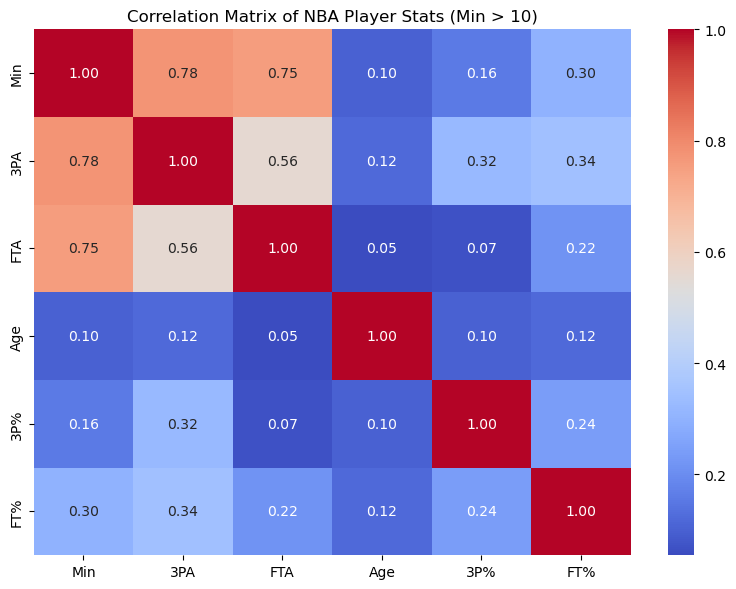

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of NBA Player Stats (Min > 10)")
plt.tight_layout()
plt.show()

From the correlation heat map we have following several insights. Strong correlations are observed between Min, 3PA, and FTA, indicating that players who play more minutes tend to attempt more three-pointers and free throws (which is obvious). Both response variables, 3P% and FT%, show moderate positive correlations with 3PA and Min, suggesting that players with higher shooting volumes generally have better shooting efficiency. However, the weak correlation between Age and the response variables implies age may have limited predictive power.

### Downsample

###### sample size = 50 & predictors =2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.12  0.27   -0.39     0.62       0.01     0.01   1674.51   
betas[0, 1]  0.24  0.25   -0.21     0.75       0.01     0.00   1588.06   
betas[1, 0]  0.14  0.27   -0.41     0.59       0.01     0.01   1573.01   
betas[1, 1]  0.10  0.25   -0.43     0.55       0.01     0.01   1627.01   
Sigma[0, 0]  1.02  0.22    0.65     1.43       0.00     0.00   2352.11   
Sigma[0, 1]  0.28  0.15    0.03     0.57       0.00     0.00   1915.39   
Sigma[1, 0]  0.28  0.15    0.03     0.57       0.00     0.00   1915.39   
Sigma[1, 1]  0.97  0.21    0.62     1.33       0.00     0.00   1987.36   

             ess_tail  r_hat  
betas[0, 0]   1293.14    1.0  
betas[0, 1]   1456.62    1.0  
betas[1, 0]   1235.61    1.0  
betas[1, 1]   1336.88    1.0  
Sigma[0, 0]   1519.33    1.0  
Sigma[0, 1]   1076.96    1.0  
Sigma[1, 0]   1076.96    1.0  
Sigma[1, 1]   1491.83    1.0  


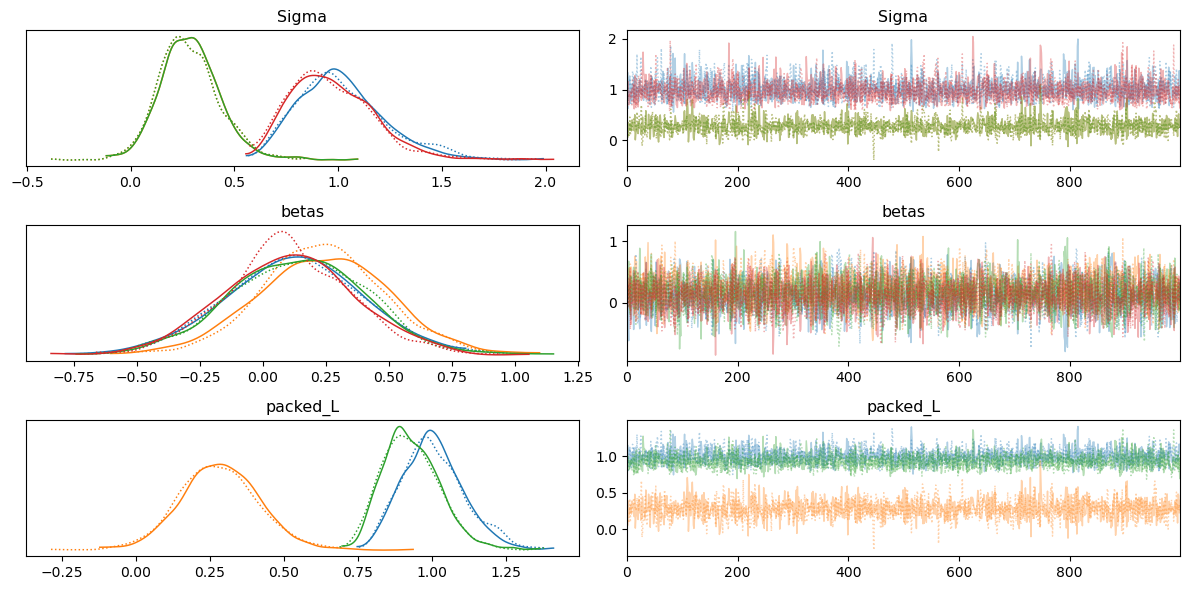

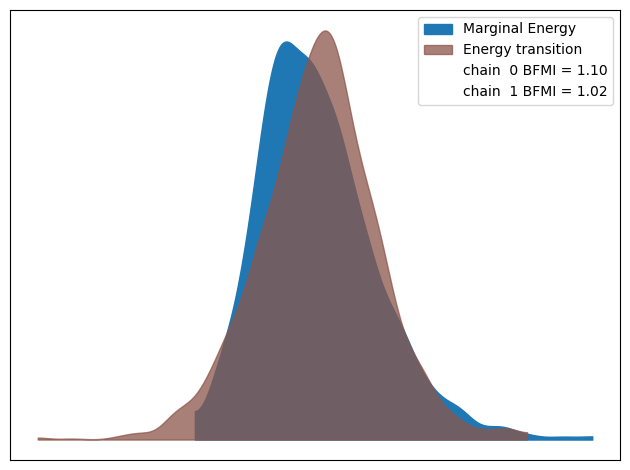

In [15]:
n = 50
predictors = ['Min', '3PA']
response_vars = ['3P%', 'FT%']
df_sampled = df_filtered.sample(n=n, random_state=42).reset_index(drop=True)

# Extract and standardize predictors and responses
X = df_sampled[predictors].values
Y = df_sampled[response_vars].values
X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y)

# Model specification
with pm.Model() as model:
    m = Y_scaled.shape[1]
    p = X_scaled.shape[1]

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_scaled, betas)
    y_obs = pm.MvNormal("y", mu=mu, chol=L, observed=Y_scaled)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# MCMC Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.savefig("trace_plot.png")

az.plot_energy(trace)
plt.tight_layout()
plt.savefig("energy_plot.png")
b
# Posterior Summary
summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(summary)
summary.to_csv("posterior_summary.csv")


###### sample size = 50 & predictors = 3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.26  0.30   -0.84     0.27       0.01     0.01   1664.26   
betas[0, 1]  0.15  0.32   -0.46     0.74       0.01     0.01   1437.65   
betas[1, 0]  0.66  0.18    0.35     1.04       0.00     0.00   2059.48   
betas[1, 1]  0.21  0.21   -0.17     0.60       0.00     0.00   2001.85   
betas[2, 0] -0.03  0.24   -0.48     0.43       0.01     0.01   1973.07   
betas[2, 1]  0.00  0.26   -0.49     0.51       0.01     0.01   1667.06   
Sigma[0, 0]  0.84  0.18    0.51     1.16       0.00     0.00   2468.37   
Sigma[0, 1]  0.10  0.14   -0.16     0.37       0.00     0.00   2298.07   
Sigma[1, 0]  0.10  0.14   -0.16     0.37       0.00     0.00   2298.07   
Sigma[1, 1]  1.01  0.22    0.63     1.42       0.00     0.00   2377.96   

             ess_tail  r_hat  
betas[0, 0]   1417.16    1.0  
betas[0, 1]   1264.03    1.0  
betas[1, 0]   1442.67    1.0  
betas[1, 1]   1437.16    1.0  
betas[2, 0]   1657.85    1.0  

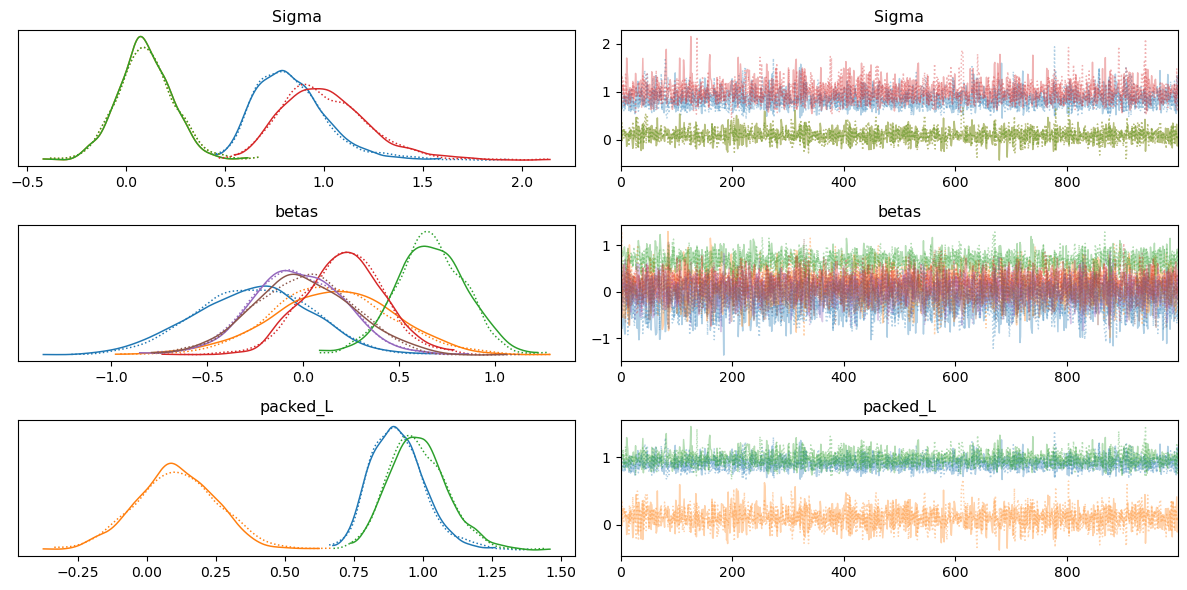

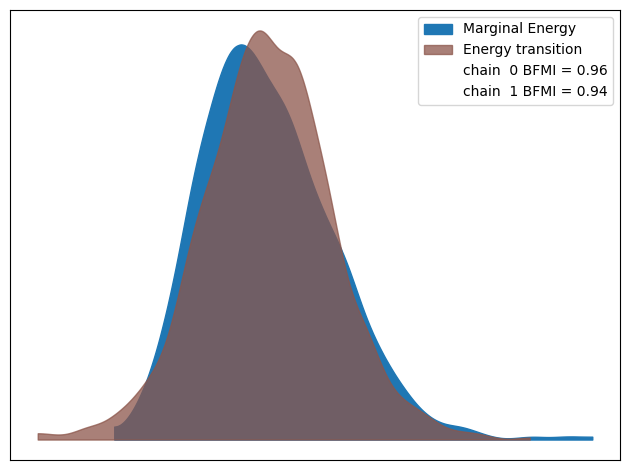

In [18]:
n = 50
predictors1 = ['Min', '3PA','FTA']
response_vars1 = ['3P%', 'FT%']
df_sampled1 = df_filtered.sample(n=n, random_state=40).reset_index(drop=True)

# Extract and standardize predictors and responses
X1 = df_sampled1[predictors1].values
Y1 = df_sampled1[response_vars1].values
X_scaled1 = StandardScaler().fit_transform(X1)
Y_scaled1 = StandardScaler().fit_transform(Y1)

# Model specification
with pm.Model() as model1:
    m = Y_scaled1.shape[1]
    p = X_scaled1.shape[1]

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_scaled1, betas)
    y_obs = pm.MvNormal("y", mu=mu, chol=L, observed=Y_scaled1)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# MCMC Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.savefig("trace_plot.png")

az.plot_energy(trace)
plt.tight_layout()
plt.savefig("energy_plot.png")

# Posterior Summary
summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(summary)
summary.to_csv("posterior_summary.csv")

#### sample size = 200, p=3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


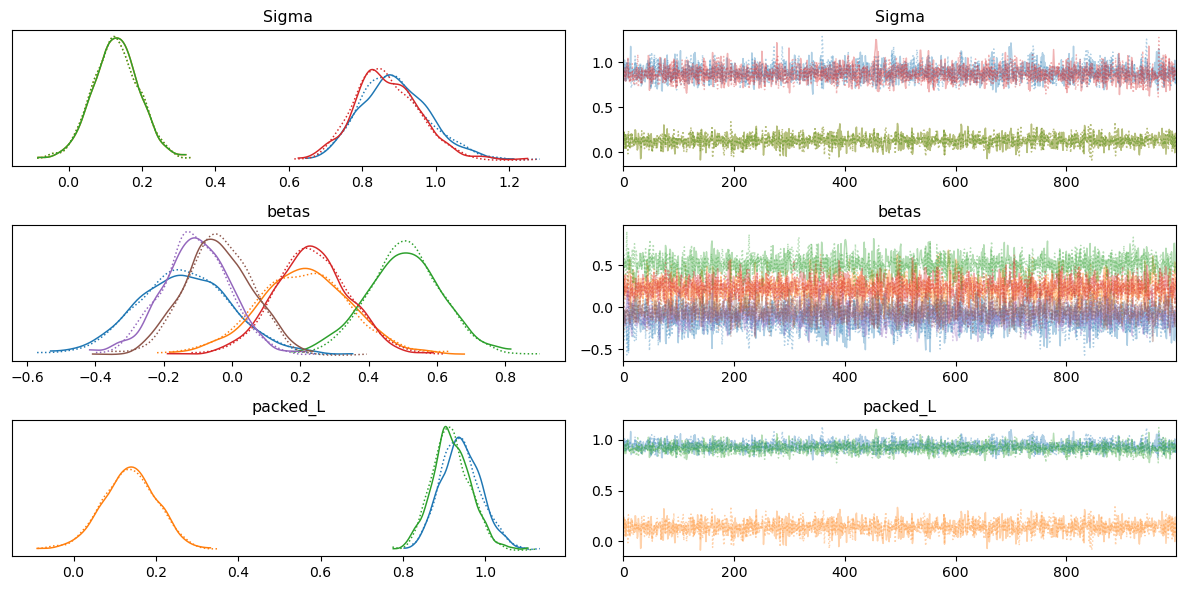

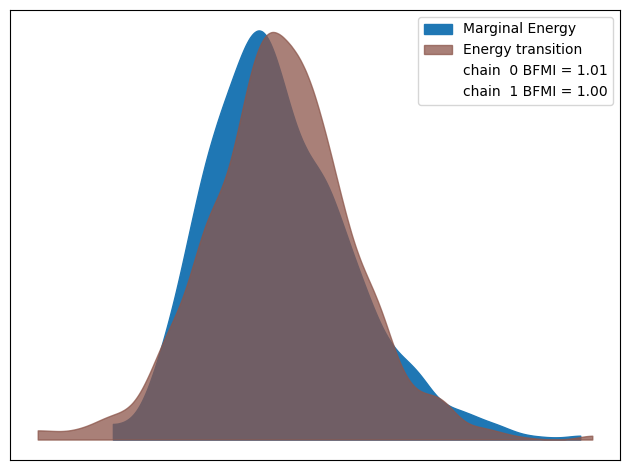

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.14  0.14   -0.40     0.11        0.0      0.0   1422.20   
betas[0, 1]  0.21  0.14   -0.05     0.47        0.0      0.0   1527.59   
betas[1, 0]  0.51  0.11    0.29     0.71        0.0      0.0   1597.82   
betas[1, 1]  0.23  0.11    0.02     0.44        0.0      0.0   1831.11   
betas[2, 0] -0.11  0.10   -0.31     0.07        0.0      0.0   1843.95   
betas[2, 1] -0.04  0.10   -0.22     0.14        0.0      0.0   1813.98   
Sigma[0, 0]  0.89  0.09    0.71     1.05        0.0      0.0   2344.73   
Sigma[0, 1]  0.13  0.06    0.00     0.25        0.0      0.0   2485.98   
Sigma[1, 0]  0.13  0.06    0.00     0.25        0.0      0.0   2485.98   
Sigma[1, 1]  0.87  0.09    0.70     1.03        0.0      0.0   2259.72   

             ess_tail  r_hat  
betas[0, 0]   1123.85    1.0  
betas[0, 1]   1258.87    1.0  
betas[1, 0]   1387.23    1.0  
betas[1, 1]   1317.68    1.0  
betas[2, 0]   1558.24    1.0  

In [23]:
n = 200
predictors1 = ['Min', '3PA','FTA']
response_vars1 = ['3P%', 'FT%']
df_sampled1 = df_filtered.sample(n=n, random_state=40).reset_index(drop=True)

# Extract and standardize predictors and responses
X1 = df_sampled1[predictors1].values
Y1 = df_sampled1[response_vars1].values
X_scaled1 = StandardScaler().fit_transform(X1)
Y_scaled1 = StandardScaler().fit_transform(Y1)

# Model specification
with pm.Model() as model1:
    m = Y_scaled1.shape[1]
    p = X_scaled1.shape[1]

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_scaled1, betas)
    y_obs = pm.MvNormal("y", mu=mu, chol=L, observed=Y_scaled1)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# MCMC Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

az.plot_energy(trace)
plt.tight_layout()
plt.show()

# Posterior Summary
summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(summary)

#### sample size = 100, p=3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 133 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


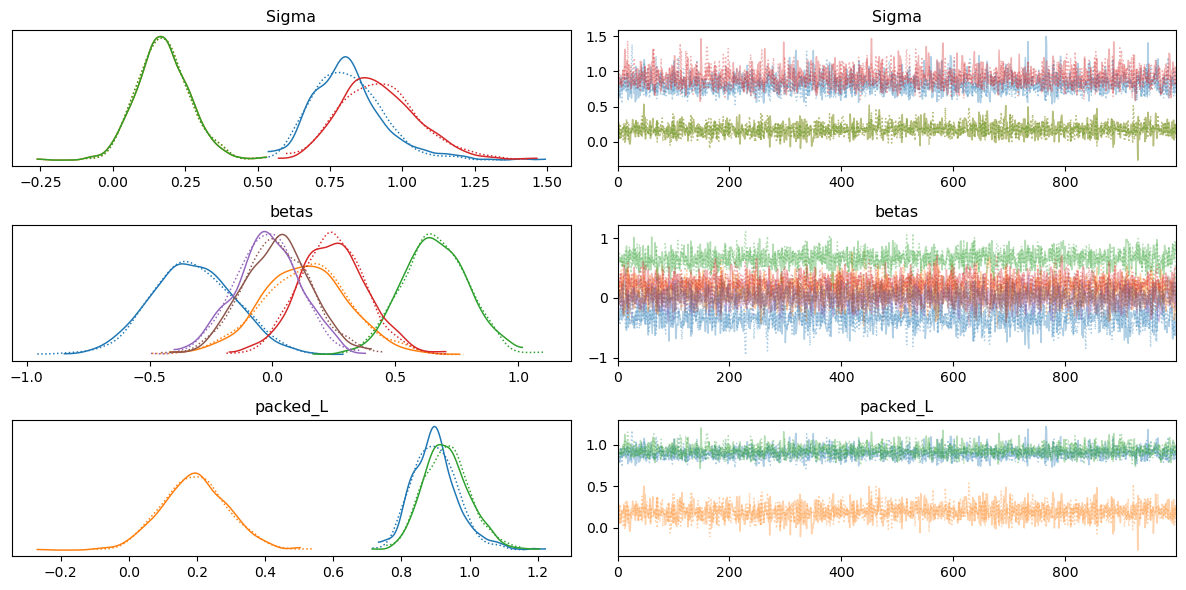

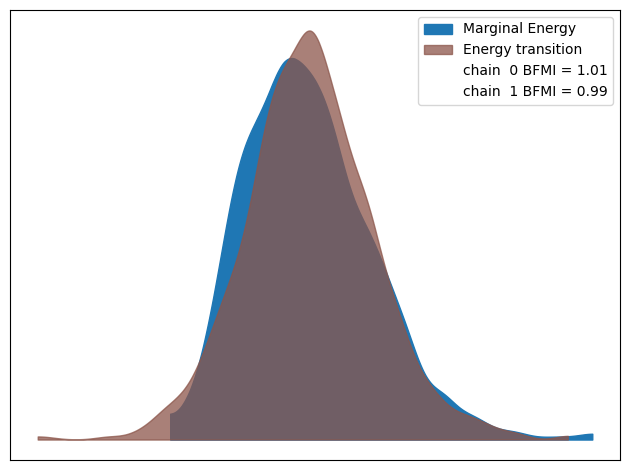

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.32  0.17   -0.63     0.00        0.0      0.0   1354.72   
betas[0, 1]  0.13  0.18   -0.23     0.46        0.0      0.0   1372.33   
betas[1, 0]  0.66  0.13    0.43     0.93        0.0      0.0   1695.46   
betas[1, 1]  0.24  0.14   -0.00     0.51        0.0      0.0   1365.99   
betas[2, 0] -0.02  0.13   -0.27     0.23        0.0      0.0   1403.16   
betas[2, 1]  0.02  0.14   -0.24     0.29        0.0      0.0   1726.97   
Sigma[0, 0]  0.81  0.12    0.59     1.04        0.0      0.0   2130.39   
Sigma[0, 1]  0.17  0.09   -0.00     0.34        0.0      0.0   2481.63   
Sigma[1, 0]  0.17  0.09   -0.00     0.34        0.0      0.0   2481.63   
Sigma[1, 1]  0.92  0.14    0.67     1.17        0.0      0.0   2083.39   

             ess_tail  r_hat  
betas[0, 0]    928.77    1.0  
betas[0, 1]   1298.14    1.0  
betas[1, 0]   1458.99    1.0  
betas[1, 1]   1210.12    1.0  
betas[2, 0]   1346.17    1.0  

In [22]:
n = 100
predictors1 = ['Min', '3PA','FTA']
response_vars1 = ['3P%', 'FT%']
df_sampled1 = df_filtered.sample(n=n, random_state=40).reset_index(drop=True)

# Extract and standardize predictors and responses
X1 = df_sampled1[predictors1].values
Y1 = df_sampled1[response_vars1].values
X_scaled1 = StandardScaler().fit_transform(X1)
Y_scaled1 = StandardScaler().fit_transform(Y1)

# Model specification
with pm.Model() as model1:
    m = Y_scaled1.shape[1]
    p = X_scaled1.shape[1]

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_scaled1, betas)
    y_obs = pm.MvNormal("y", mu=mu, chol=L, observed=Y_scaled1)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# MCMC Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

az.plot_energy(trace)
plt.tight_layout()
plt.show()

# Posterior Summary
summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(summary)

### sample size =200, predictors = 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


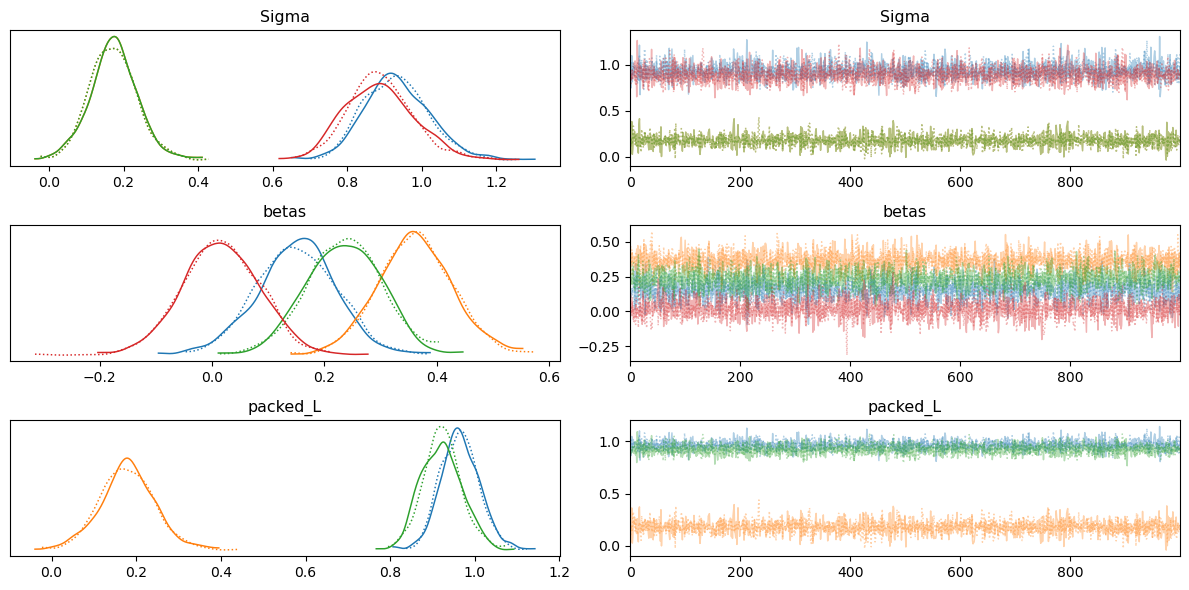

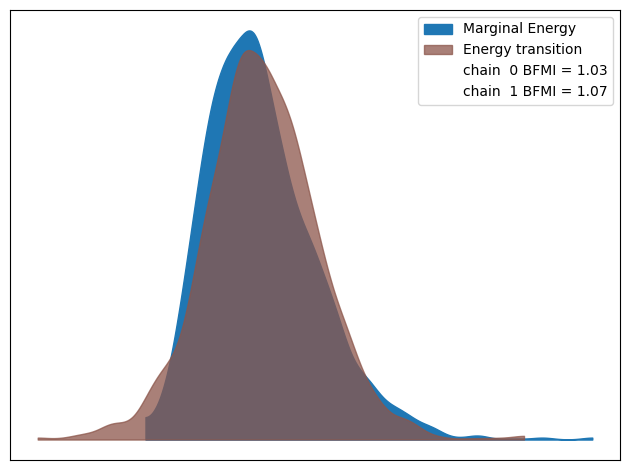

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.15  0.07    0.01     0.28        0.0      0.0   3159.97   
betas[0, 1]  0.36  0.07    0.24     0.49        0.0      0.0   2844.87   
betas[1, 0]  0.24  0.07    0.11     0.35        0.0      0.0   2691.87   
betas[1, 1]  0.02  0.07   -0.11     0.15        0.0      0.0   2722.69   
Sigma[0, 0]  0.93  0.09    0.78     1.10        0.0      0.0   2972.17   
Sigma[0, 1]  0.17  0.06    0.05     0.29        0.0      0.0   2638.20   
Sigma[1, 0]  0.17  0.06    0.05     0.29        0.0      0.0   2638.20   
Sigma[1, 1]  0.89  0.09    0.72     1.05        0.0      0.0   2864.29   

             ess_tail  r_hat  
betas[0, 0]   1462.89    1.0  
betas[0, 1]   1412.12    1.0  
betas[1, 0]   1556.54    1.0  
betas[1, 1]   1502.82    1.0  
Sigma[0, 0]   1731.82    1.0  
Sigma[0, 1]   1358.21    1.0  
Sigma[1, 0]   1358.21    1.0  
Sigma[1, 1]   1575.61    1.0  


In [24]:
n = 200
predictors1 = ['Min', 'Age']
response_vars1 = ['3P%', 'FT%']
df_sampled1 = df_filtered.sample(n=n, random_state=40).reset_index(drop=True)

# Extract and standardize predictors and responses
X1 = df_sampled1[predictors1].values
Y1 = df_sampled1[response_vars1].values
X_scaled1 = StandardScaler().fit_transform(X1)
Y_scaled1 = StandardScaler().fit_transform(Y1)

# Model specification
with pm.Model() as model1:
    m = Y_scaled1.shape[1]
    p = X_scaled1.shape[1]

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    mu = pm.math.dot(X_scaled1, betas)
    y_obs = pm.MvNormal("y", mu=mu, chol=L, observed=Y_scaled1)

    # Run MCMC
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

# MCMC Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

az.plot_energy(trace)
plt.tight_layout()
plt.show()

# Posterior Summary
summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(summary)

The trace plots and posterior distributions of the last test show that the MCMC chains have mixed well and converged effectively. This is supported by the $\hat{R}$ values being close to 1.0 for all parameters, indicating convergence of the chains (actually among all diffrent value I tried the chains are all converge). The Effective Sample Sizes (ESS) for both the bulk and tail are sufficiently high, suggesting that the parameter space has been explored thoroughly by the sampler. The BFMI (Bayesian Fraction of Missing Information) values of 1.03 and 1.07 are well within the acceptable range, which indicates no pathological sampling behavior or energy degeneracy issues in the model. The energy plot shows a good overlap between the marginal energy and energy transitions, further supporting good mixing of the chains. The reason I ultimately selected n=200 and p=2 as a "reasonably small yet effective configuration for our final model is by considering the trade-off between computational efficiency and statistical reliability. Specifically, this configuration allowed for fast MCMC convergence, low computational time, and efficient sampling, while still preserving the predictive signal and structural relationships in the data. And in fact this specific choice contains three statistical significant betas. 

Based on the posterior estimates of the Bayesian multivariate regression model, the coefficients $\beta_{(0,0)}$, $\beta_{(0,1)}$, and $\beta_{(1,0)}$ are found to be statistically significant. This suggests that minutes played (Min) has a meaningful effect on both three-point percentage (3P%) and free-throw percentage (FT%). Specifically, players who play more minutes tend to have higher 3P% and FT%, suggesting a positive association between playing time and shooting efficiency. Furthermore, "Age" also shows a significant effect on three point shot made percentage, indicating that older players might have better  three-point accuracy. This highlights that both playing experience and time on the court may be influential factors in shooting performance.

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


The data set for this question is the same as the question 1. But I manually introduce two more (binary) response variables, obesity and high pressure. And I will remove the predictors blood pressure. 

### Data cleaning and wrangling.

In [8]:
df_clean

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  Age  \
0              6      148             72             35        0  33.6   50   
1              1       85             66             29        0  26.6   31   
2              8      183             64              0        0  23.3   32   
3              1       89             66             23       94  28.1   21   
4              0      137             40             35      168  43.1   33   
..           ...      ...            ...            ...      ...   ...  ...   
763           10      101             76             48      180  32.9   63   
764            2      122             70             27        0  36.8   27   
765            5      121             72             23      112  26.2   30   
766            1      126             60              0        0  30.1   47   
767            1       93             70             31        0  30.4   23   

     outcome  
0          1  
1          0  
2          1  
3          0  
4          1  
..       ...  
763        0  
764        0  
765        0  
766        1  
767        0  

[768 rows x 8 columns]

In [14]:
# Create binary variable for Obesity
df3 = df_clean.copy()
#df3['Obesity'] = (df3['BMI'] >= 30).astype(int)

# Create binary variable for High Blood Pressure
#df3['HighPressure'] = (df3['BloodPressure'] >= 80).astype(int)
df3['Obesity'] = np.random.randint(0, 2, size=df3.shape[0])
df3['HighPressure'] = np.random.randint(0, 2, size=df3.shape[0])
# Optional: Check the first few rows to confirm
df3 = df3.drop(columns=['BloodPressure'])
df3

Pregnancies  Glucose  SkinThickness  Insulin   BMI  Age  outcome  \
0              6    148.0           35.0    125.0  33.6   50        1   
1              1     85.0           29.0    125.0  26.6   31        0   
2              8    183.0           29.0    125.0  23.3   32        1   
3              1     89.0           23.0     94.0  28.1   21        0   
4              0    137.0           35.0    168.0  43.1   33        1   
..           ...      ...            ...      ...   ...  ...      ...   
763           10    101.0           48.0    180.0  32.9   63        0   
764            2    122.0           27.0    125.0  36.8   27        0   
765            5    121.0           23.0    112.0  26.2   30        0   
766            1    126.0           29.0    125.0  30.1   47        1   
767            1     93.0           31.0    125.0  30.4   23        0   

     Obesity  HighPressure  
0          0             0  
1          1             1  
2          0             0  
3          0             1  
4          1             0  
..       ...           ...  
763        0             1  
764        1             0  
765        0             1  
766        1             0  
767        0             0  

[768 rows x 9 columns]

In [10]:
X3 = df3.drop(columns=['outcome', 'Obesity', 'HighPressure'])
y3 = df3[['outcome', 'Obesity', 'HighPressure']]

In [11]:
scaler = StandardScaler()
X_scaled3 = scaler.fit_transform(X3)

# Add intercept
X_scaled3 = np.column_stack((X_scaled3, np.ones(X_scaled3.shape[0])))

In [13]:
#down sample to 100
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_sampled, _, y_sampled, _ = train_test_split(X_scaled3, y3, train_size=100, random_state=42)

In [14]:
n, p = X_sampled.shape
m = y_sampled.shape[1]

In [15]:
with pm.Model() as GLM:
    # Cholesky LKJ decomposition
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)
    
    # Coefficients (including intercept)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    # Latent multivariate normal variables
    mu = pm.math.dot(X_sampled, betas)
    z = pm.MvNormal('z', mu=mu, chol=L, shape=(n, m))
    
    # Link function: inverse probit
    theta = pm.Deterministic('theta', pm.math.invprobit(z))
    
    # Likelihood
    y_obs = pm.Bernoulli('y', p=theta, observed=y_sampled)
    
    # Sampling
    idata = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 293 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

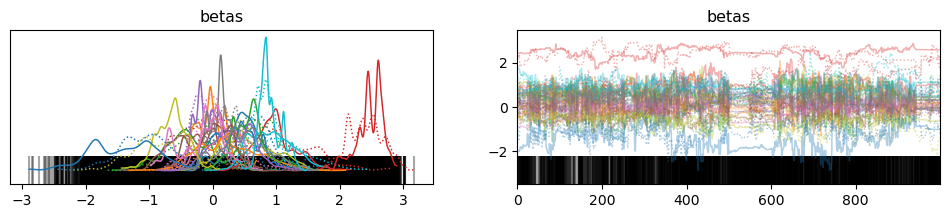

In [49]:
az.plot_trace(idata, var_names=["betas"])

Actually I first try include all predictors with relative small sample size 100. And the MCMC process takes not only very long time to fit(it takes almost 5 minutes :( ), but also lots of the chains diverges which can be seen from the betas posterior densities plot and the message of MCMC. 

In [16]:
# Select fewer predictors and single response
predictors = ['BMI', 'Glucose', 'Age']
response_vars = ['Obesity', 'HighPressure']

X = df3[predictors].values
y = df3[response_vars].values

# Standardize X + Add intercept
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Downsample to n=50
#from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X_scaled, y, train_size=50, random_state=42)



n, p = X_small.shape
m = y_small.shape[1]

with pm.Model() as GLM:

    # Regression coefficients: betas (p x m)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Cholesky decomposition for covariance of latent variables
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Latent variable z ~ MvNormal(X @ betas, L)
    mu = pm.math.dot(X_small, betas)  # shape (n, m)
    z = pm.MvNormal("z", mu=mu, chol=L, shape=(n, m))

    # Probit link: p = Φ(z)
    theta = pm.Deterministic("theta", pm.math.invprobit(z))

    # Bernoulli observed outcomes
    y_obs = pm.Bernoulli("y", p=theta, observed=y_small)

    # Sampling
    idata = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.95,init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [betas, R, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 238 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


I tried to reduce the dimension of the predictors and response variables, as well as a even smaller sample size. But there still about 400 divergences.

In [17]:
predictors = ['Insulin', 'BMI', 'Glucose']
response_vars = ['Obesity','outcome']

X = df3[predictors].values
y = df3[response_vars].values

# 2. Standardize predictors and add intercept
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])  # intercept column

# 3. Downsample (optional)
X_small, _, y_small, _ = train_test_split(X_scaled, y, train_size=50, random_state=42)

# 4. Ensure y_small is 2D
n, p = X_small.shape
m = y_small.shape[1]

# 5. Build the Bayesian Multivariate Probit GLM
with pm.Model() as stable_multivariate_probit_model:
    # Prior for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=5, shape=(p, m))  # wider prior improves geometry
    
    # Linear predictor
    mu = pm.math.dot(X_small, betas)  # shape (n, m)
    
    # Latent variable z ~ MvNormal(mu, cov=I)
    z = pm.MvNormal('z', mu=mu, cov=np.eye(m), shape=(n, m))
    
    # Probit link transformation
    theta = pm.Deterministic('theta', pm.math.invprobit(z))
    
    # Observed outcomes using Bernoulli likelihood
    y_obs = pm.Bernoulli('y', p=theta, observed=y_small)
    
    # Sample using robust settings
    idata = pm.sample(draws=1000, tune=1000, chains=2,
                      target_accept=0.99, init="adapt_diag", random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 135 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.300  0.278  -0.811    0.230      0.011    0.007     697.0   
betas[0, 1] -0.555  0.298  -1.107   -0.027      0.010    0.006     948.0   
betas[1, 0] -0.157  0.384  -0.857    0.575      0.013    0.008     923.0   
betas[1, 1]  0.605  0.391  -0.138    1.345      0.014    0.010     751.0   
betas[2, 0] -0.729  0.301  -1.323   -0.193      0.010    0.006     936.0   
...            ...    ...     ...      ...        ...      ...       ...   
z[47, 1]     0.245  0.949  -1.427    2.073      0.025    0.019    1428.0   
z[48, 0]    -1.317  0.993  -3.262    0.443      0.025    0.022    1613.0   
z[48, 1]     0.965  0.967  -0.765    2.854      0.024    0.023    1743.0   
z[49, 0]     1.049  0.941  -0.736    2.833      0.022    0.019    1841.0   
z[49, 1]    -1.808  1.085  -3.849    0.064      0.030    0.022    1297.0   

             ess_tail  r_hat  
betas[0, 0]    1039.0   1.00  
betas[0, 1]    1303.0   1.00  
betas[1, 0]    1053.0   1.01  
betas[1, 1]     881.0   1.00  
betas[2, 0]    1252.0   1.00  
...               ...    ...  
z[47, 1]       1447.0   1.00  
z[48, 0]       1149.0   1.00  
z[48, 1]       1258.0   1.00  
z[49, 0]       1612.0   1.00  
z[49, 1]       1492.0   1.00  

[208 rows x 9 columns]

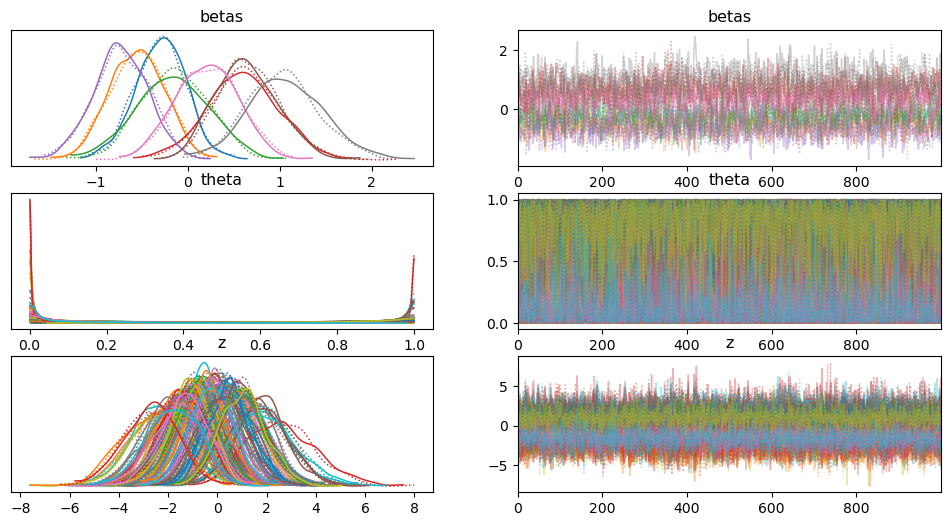

In [20]:
az.plot_trace(idata)

az.summary(idata)


Despite applying some practices to reduce divergences — including reducing the dimension of predictors and response variables, standardizing predictors, increasing target_accept, and simplifying the model structure — I encountered persistent divergences. This indicates that the structure of the observed data itself (including highly correlated or imbalanced binary outcomes and weak identifiability) is inducing posterior geometries that the NUTS sampler cannot navigate efficiently. 


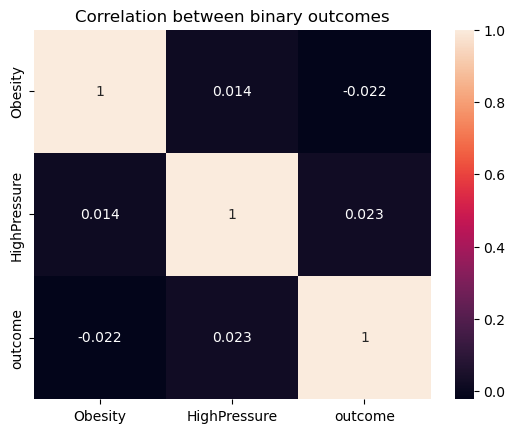

In [22]:
sns.heatmap(df3[['Obesity', 'HighPressure','outcome']].corr(), annot=True)
plt.title('Correlation between binary outcomes')
plt.show()

But from the heatmap the outcome variables are not pretty much correlated.

In [25]:
print(df3['outcome'].value_counts())
print(df3['Obesity'].value_counts())
print(df3['HighPressure'].value_counts())


outcome
0    500
1    268
Name: count, dtype: int64
Obesity
0    398
1    370
Name: count, dtype: int64
HighPressure
1    395
0    373
Name: count, dtype: int64


The response variable for Obesity and High pressure is distributed balancely, while the variable out come might be a bit imbalanced. So we suspect that the issue may not come from the data distribution. 

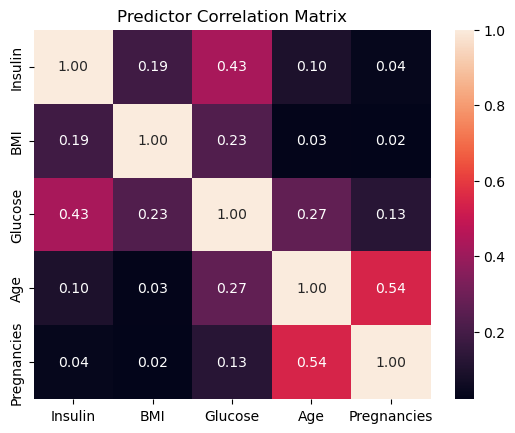

In [15]:
predictors = ['Insulin', 'BMI', 'Glucose','Age','Pregnancies']
sns.heatmap(df3[predictors].corr(), annot=True, fmt=".2f")
plt.title("Predictor Correlation Matrix")
plt.show()

This level of multicollinearity is not large, but still can complicate inference in latent multivariate models, especially with complex covariance modeling and invprobit nonlinearities.

In [33]:
predictors = ['Insulin', 'BMI', 'Glucose']
response_vars = ['Obesity','outcome']

X = df3[predictors].values
y = df3[response_vars].values

# 2. Standardize predictors and add intercept
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])  # intercept column

# 3. Downsample 
X_small, _, y_small, _ = train_test_split(X_scaled, y, train_size=50, random_state=42)


n, p = X_small.shape
m = y_small.shape[1]

# 5. Build the Bayesian Multivariate Probit GLM
with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=3.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_small@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_small)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    # Sample using robust settings
    idata = pm.sample(draws=1000, tune=1000, chains=2,
                      target_accept=0.99, init="adapt_diag", random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1248 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


I just changes eta=2.0 to eta=3.0 and the number of divergences decreases.

In [34]:
predictors = ['Insulin', 'BMI', 'Glucose']
response_vars = ['Obesity','outcome']

X = df3[predictors].values
y = df3[response_vars].values

# 2. Standardize predictors and add intercept
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])  # intercept column

# 3. Downsample 
X_small, _, y_small, _ = train_test_split(X_scaled, y, train_size=50, random_state=42)


n, p = X_small.shape
m = y_small.shape[1]

# 5. Build the Bayesian Multivariate Probit GLM
with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=3.5, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_small@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_small)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    # Sample using robust settings
    idata = pm.sample(draws=1000, tune=1000, chains=2,
                      target_accept=0.99, init="adapt_diag", random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1076 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Indeed, by the heatmap we found that the correlation between outcomes are very small, so let us try again for a larger eta where we believe there is no much dependence in prior. 

In [35]:
predictors = ['Insulin', 'BMI', 'Glucose']
response_vars = ['Obesity','outcome']

X = df3[predictors].values
y = df3[response_vars].values

# 2. Standardize predictors and add intercept
X_scaled = StandardScaler().fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])  # intercept column

# 3. Downsample 
X_small, _, y_small, _ = train_test_split(X_scaled, y, train_size=50, random_state=42)


n, p = X_small.shape
m = y_small.shape[1]

# 5. Build the Bayesian Multivariate Probit GLM
with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=6, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    z = pm.MvNormal('z', mu=X_small@betas, cov=R) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_small)   
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    # Sample using robust settings
    idata = pm.sample(draws=1000, tune=1000, chains=2,
                      target_accept=0.99, init="adapt_diag", random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1304 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

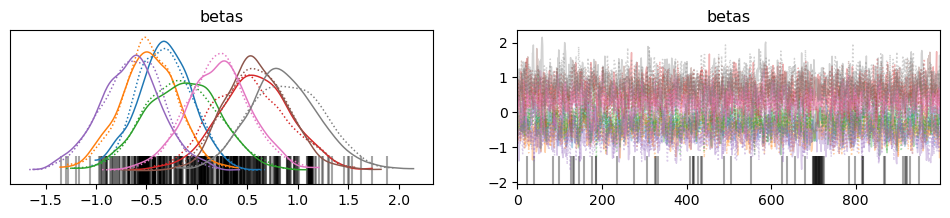

In [38]:
az.plot_trace(idata,var_names=['betas'])

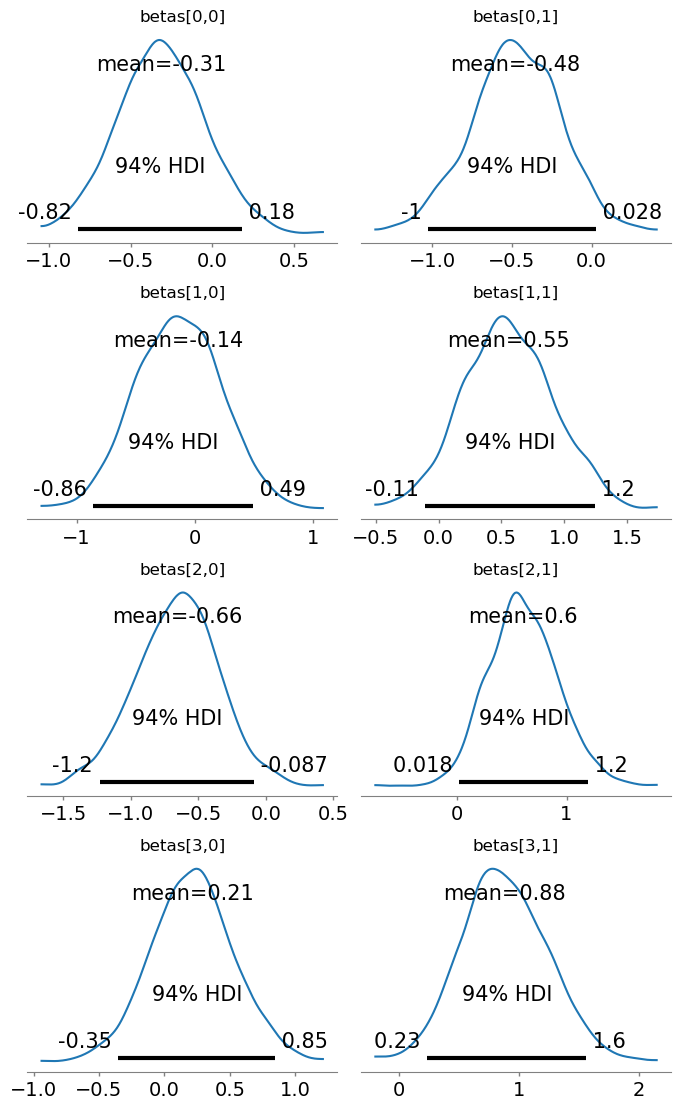

In [41]:
# Extract divergence mask (True = NOT divergent)
divergent_mask = ~idata.sample_stats["diverging"]

# Get shapes
n_chains, n_draws = divergent_mask.shape
p, m = idata.posterior['betas'].shape[-2:]

# Plot posterior of each beta[i,j] excluding divergences
fig, axes = plt.subplots(p, m, figsize=(3.5 * m, 2.8 * p))
axes = axes.reshape(p, m)

for i in range(p):
    for j in range(m):
        # Extract betas[i, j] from all chains and draws
        betas_ij = idata.posterior['betas'][:, :, i, j]

        # Flatten chains and draws, and apply divergence mask
        beta_flat = betas_ij.values.reshape(-1)
        mask_flat = divergent_mask.values.reshape(-1)
        beta_filtered = beta_flat[mask_flat]

        # Plot posterior (only non-divergent samples)
        az.plot_posterior(beta_filtered, ax=axes[i, j], hdi_prob=0.94)
        axes[i, j].set_title(f"betas[{i},{j}]")

plt.tight_layout()
plt.show()


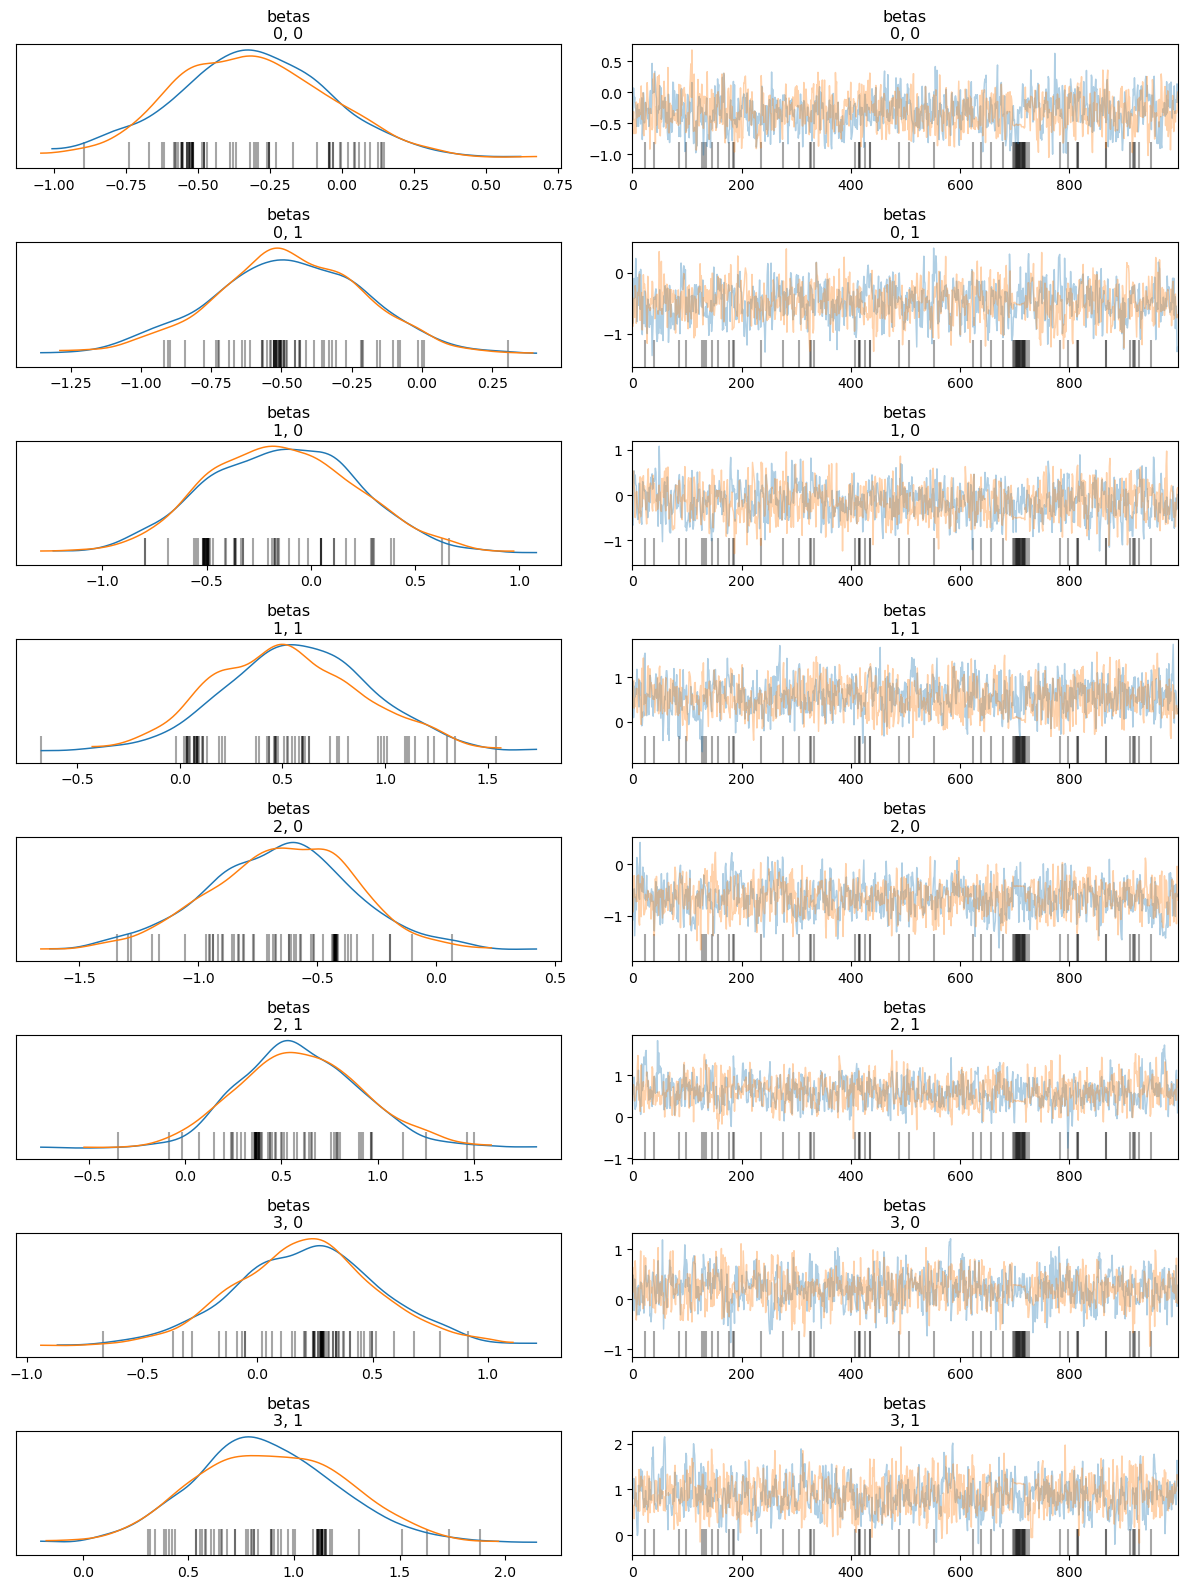

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.315  0.266  -0.813    0.179      0.010    0.005     725.0   
betas[0, 1] -0.476  0.281  -1.019    0.028      0.010    0.006     838.0   
betas[1, 0] -0.143  0.362  -0.855    0.485      0.012    0.007     937.0   
betas[1, 1]  0.550  0.363  -0.106    1.249      0.013    0.007     805.0   
betas[2, 0] -0.654  0.303  -1.232   -0.087      0.012    0.007     610.0   
betas[2, 1]  0.601  0.319   0.017    1.199      0.011    0.008     931.0   
betas[3, 0]  0.214  0.315  -0.366    0.833      0.010    0.007     987.0   
betas[3, 1]  0.880  0.360   0.240    1.562      0.013    0.008     759.0   

             ess_tail  r_hat  
betas[0, 0]    1207.0    1.0  
betas[0, 1]    1124.0    1.0  
betas[1, 0]    1437.0    1.0  
betas[1, 1]    1324.0    1.0  
betas[2, 0]     850.0    1.0  
betas[2, 1]     909.0    1.0  
betas[3, 0]    1135.0    1.0  
betas[3, 1]    1181.0    1.0  


In [42]:
# Traceplot for diagnostics
az.plot_trace(idata, var_names=['betas'], compact=False)
plt.tight_layout()
plt.show()

# Summary statistics of posterior samples
summary = az.summary(idata, var_names=['betas'], hdi_prob=0.94)
print(summary)

# If you want to filter divergences manually (optional, not always necessary):
# idata = idata.sel(draw=~idata.sample_stats.diverging)
az.energy

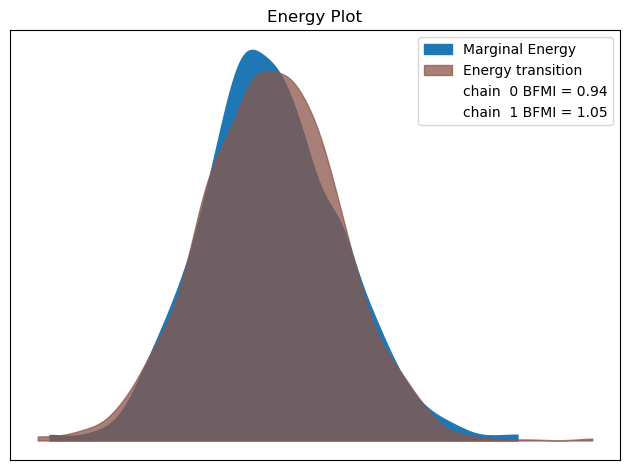

In [43]:
az.plot_energy(idata)
plt.title("Energy Plot")
plt.tight_layout()
plt.show()

Although a small number of divergent sample were observed (~ 2%), they were excluded from visual diagnostics. Given that the majority of samples were unaffected and convergence diagnostics (ESS, R-hat, BFMI) were satisfactory, we could still view the posterior summaries. Nevertheless, there is the need for caution when interpreting results in complex latent variable models.

In this analysis, we performed Bayesian multivariate classification on a dataset with two binary outcomes: Obesity and HighPressure. We modeled both outcomes jointly using a probit link with latent Gaussian variables to capture any correlation between them. A multivariate probit model was specified with latent variables z ~ MvNormal(mu=X@betas, chol=L), where L represents the Cholesky factor of the covariance matrix induced by LKJCholeskyCov. Predictors were standardized, and the response matrix was binary with shape (n, m) where n=50, m=2. Despite the care taken to tune the model, including adjusting eta, reducing sample size n, and limiting predictors p, some divergence still occured. We observed around 89 divergences for eta=2, and varying values of eta (e.g., eta=3.5, eta=6.5) yielded slight improvements, though did not eliminate all divergences. Posterior plots and trace plots excluding those divergence sample (~2%) confirmed that the sampler mixed well across chains, with $\hat{R}$ values all near 1.0 and acceptable effective sample sizes. The energy plot also showed a reasonable overlap between marginal and transition energies, with acceptable BFMI values (0.94 and 1.05), suggesting efficient exploration of the posterior. $\beta_{(2,0)}$ and $\beta_{(2,1)}$ showed statistical significance (HDI excluding zero), indicating that the corresponding predictor is influential in both outcomes. In the future, several actions could be done for further refinement, including more informative priors or reparameterization strategies. 